<a href="https://colab.research.google.com/github/sandhrabijoy/Store-Item-Demand-Forecasting/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up basics for forecasting pipeline


In [4]:
import numpy as np
import pandas as pd

import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x:'%.2f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font='Arial',rc={
    "axes.axisbelow":False,
    "axes.edgecolor":"lightgrey",
    "axes.facecolor":"None",
    "axes.grid":False,
    "axes.labelcolor":"dimgrey",
    "axes.spines.right":False,
    "axes.spines.top":False,
    "figure.facecolor":"white",
    "lines.solid_capstyle":"round",
    "patch.edgecolor":"w",
    "patch.force_edgecolor":True,
    "text.color":"dimgrey",
    "xtick.bottom":False,
    "xtick.color":"dimgrey",
    "xtick.direction":"out",
    "xtick.top":False,
    "ytick.color":"dimgrey",
    "ytick.direction":"out",
    "ytick.left":False,
    "ytick.right":False
})

In [5]:
def missing_data(input_data):
  total = input_data.isnull().sum()
  percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
  table = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  types=[]
  for col in input_data.columns:
    dtype=str(input_data[col].dtype)
    types.append(dtype)
  table["Types"]=types
  return(pd.DataFrame(table))

def mape(actual,pred):
  actual,pred=np.array(actual),np.array(pred)
  return np.mean(np.abs(actual-pred)/actual)*100

Reading Data

In [11]:
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

In [12]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [13]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [16]:
df['date'] = pd.to_datetime(df['date'].str.replace('-', ''), format='%Y%m%d')

In [18]:
min(df['date']),max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [19]:
agg_df=df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [20]:
total_sales_df= agg_df.pivot(index='date',columns='family',values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


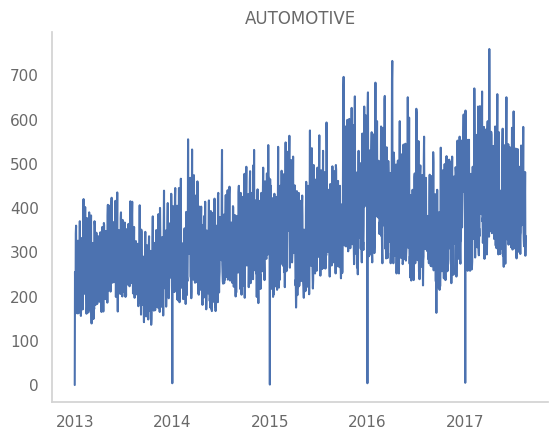

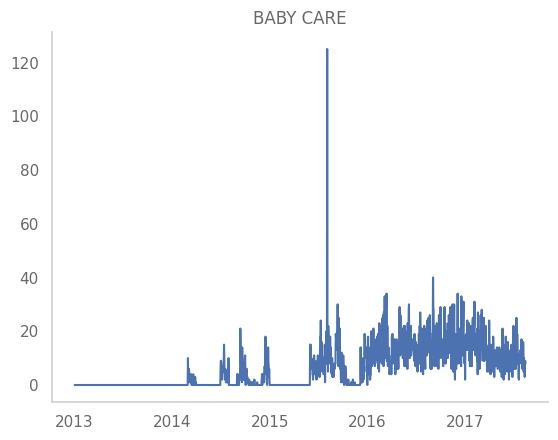

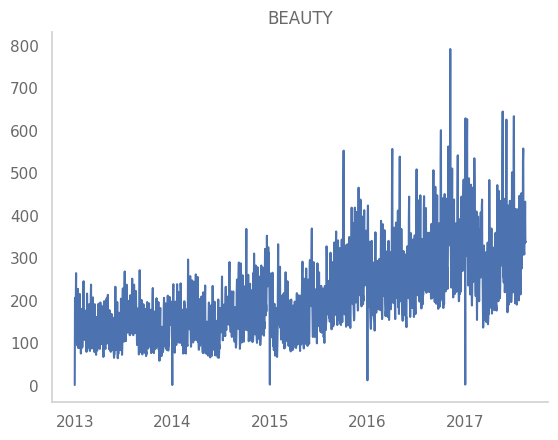

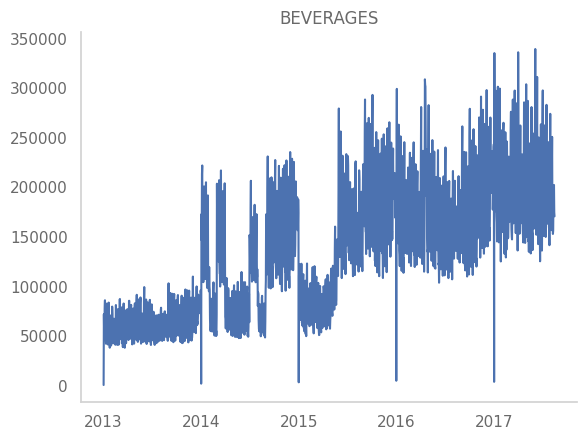

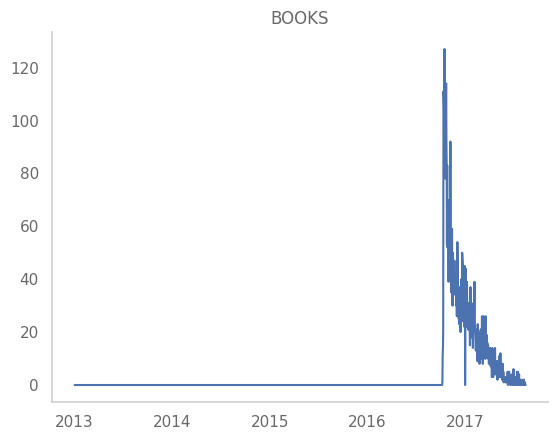

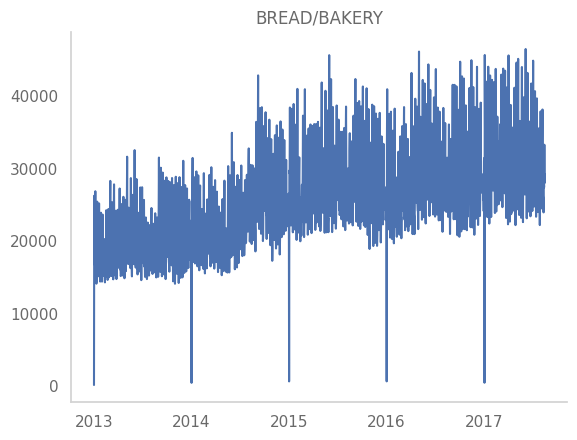

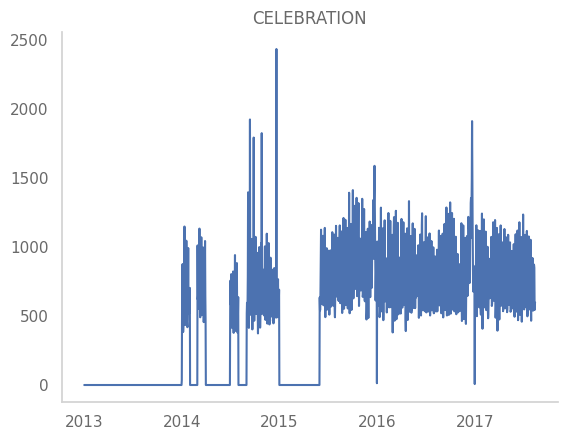

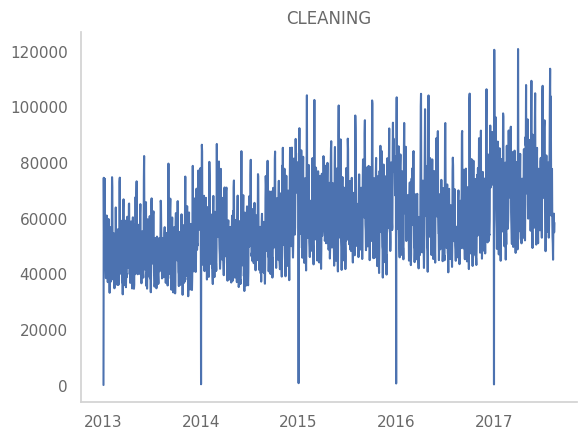

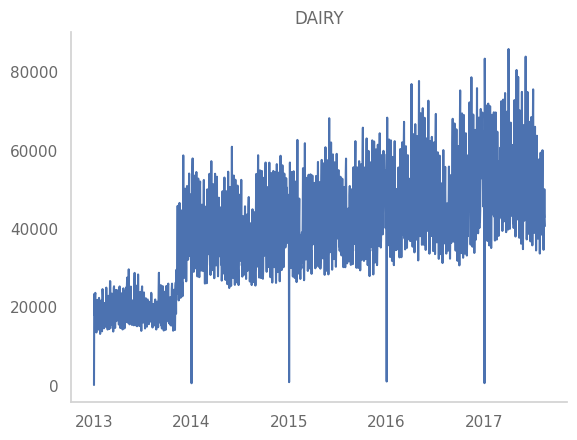

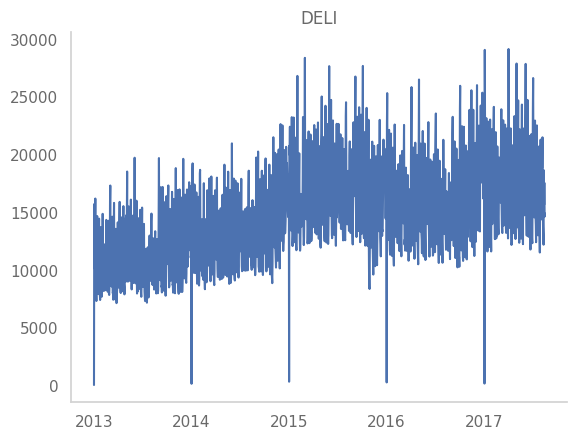

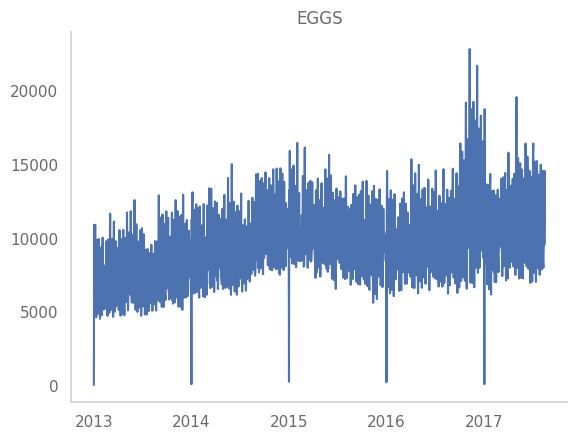

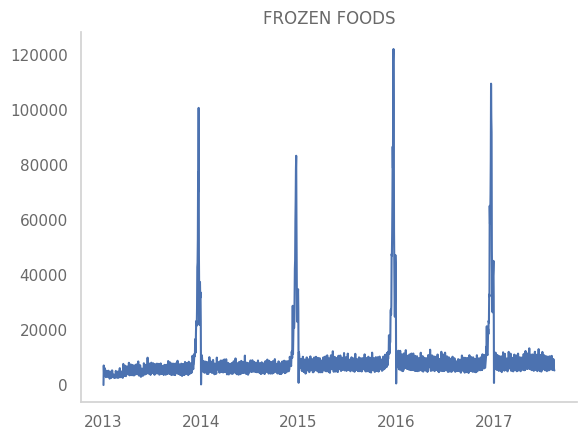

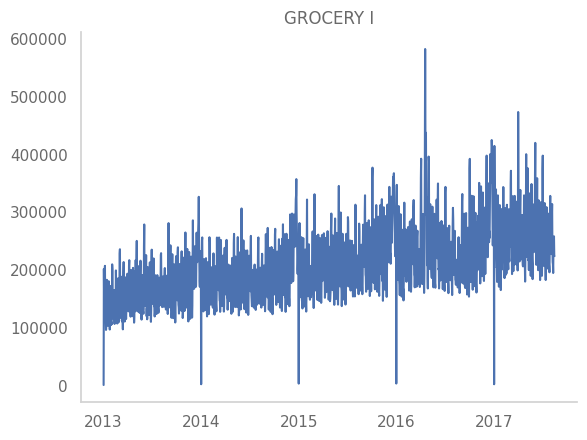

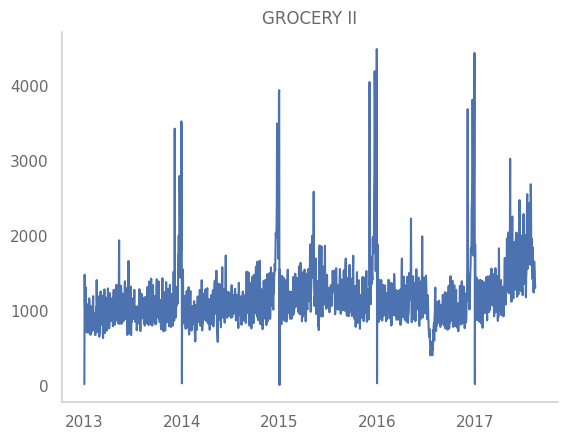

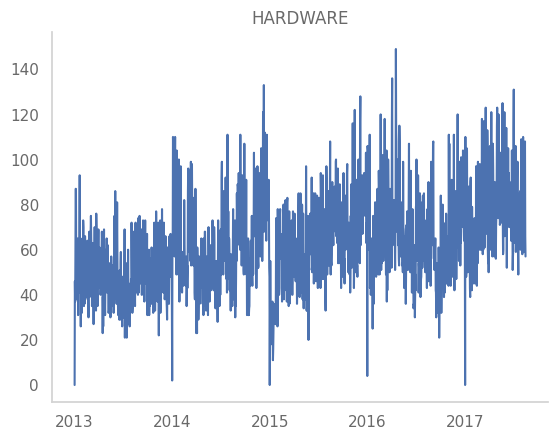

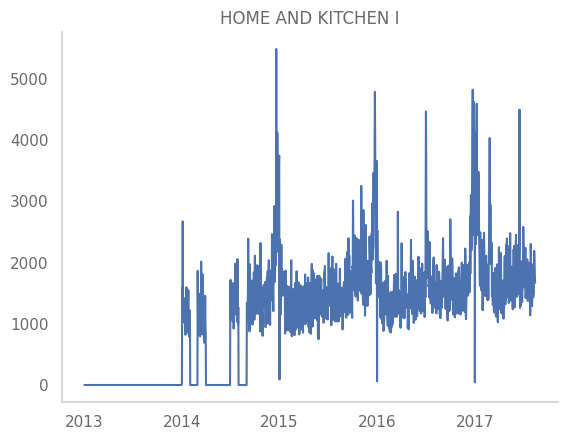

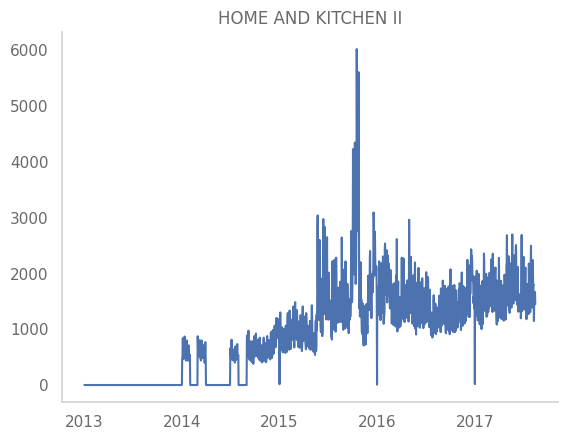

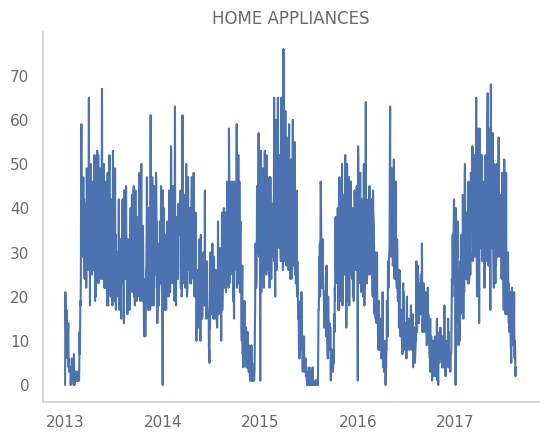

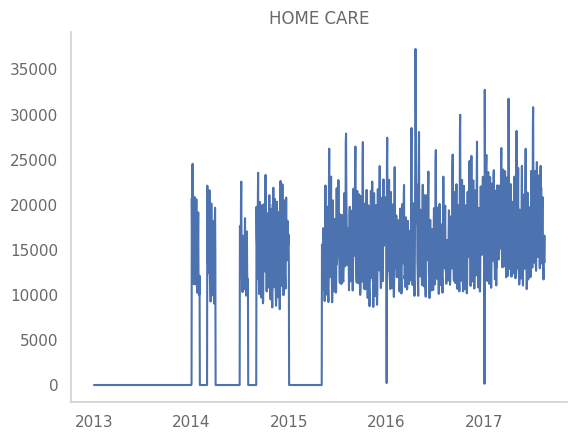

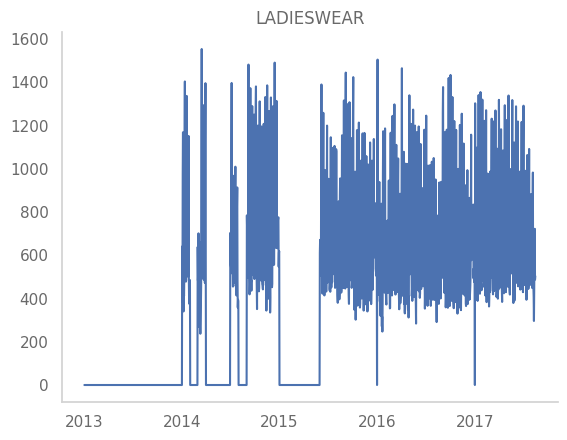

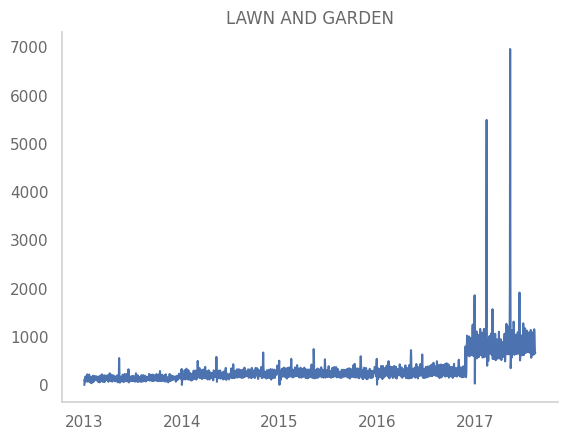

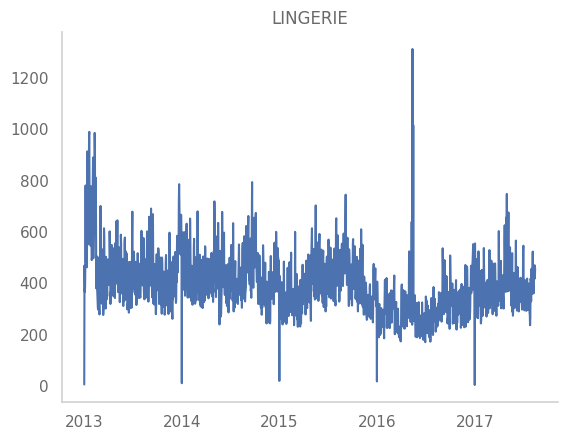

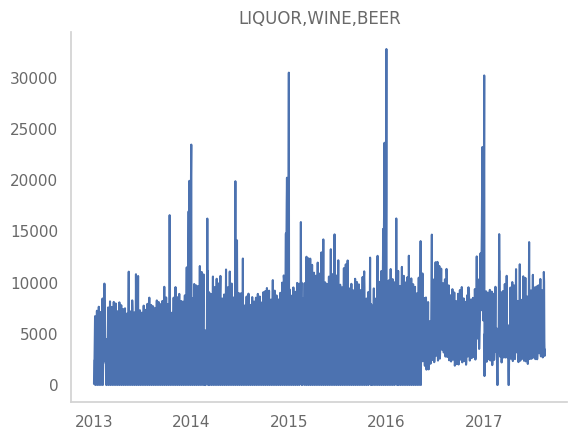

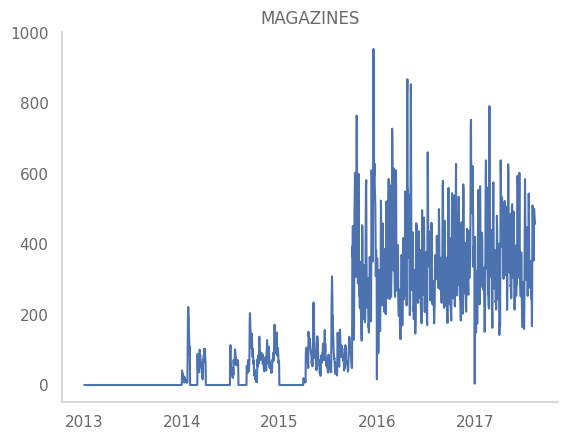

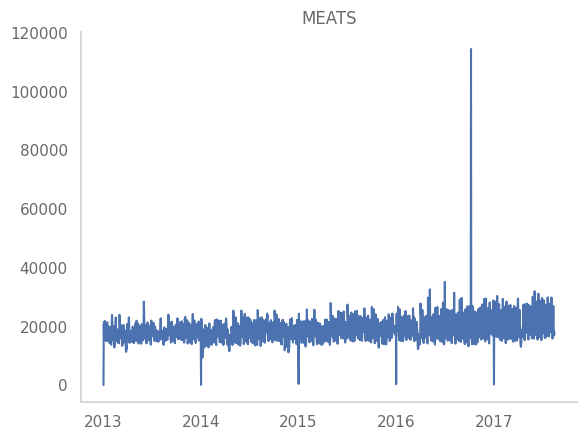

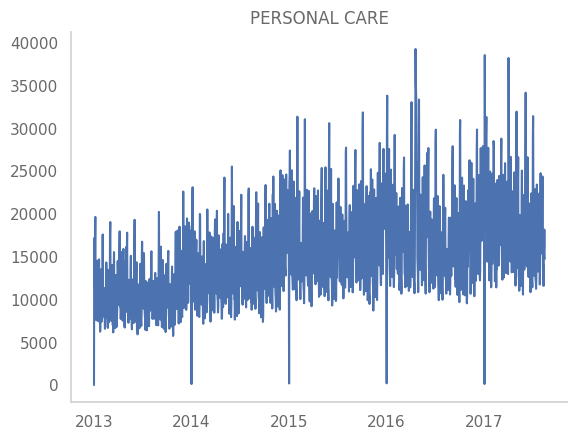

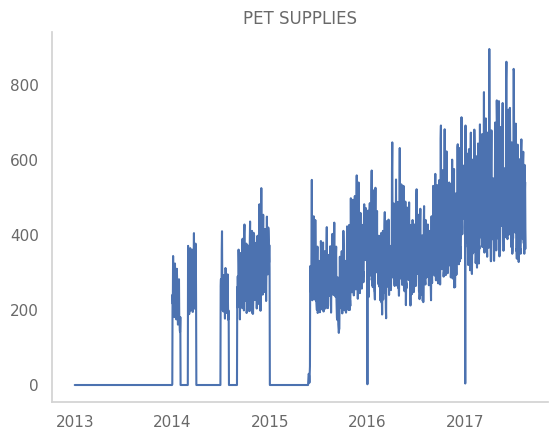

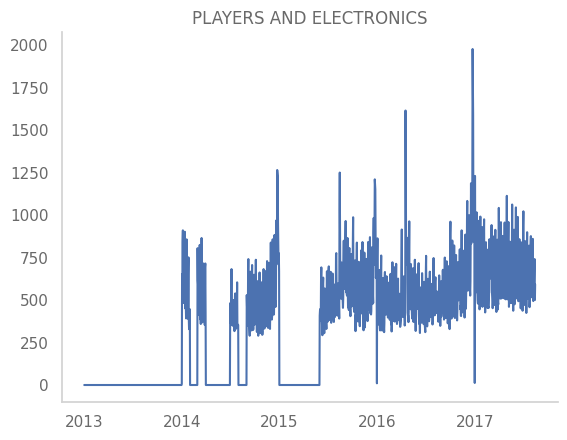

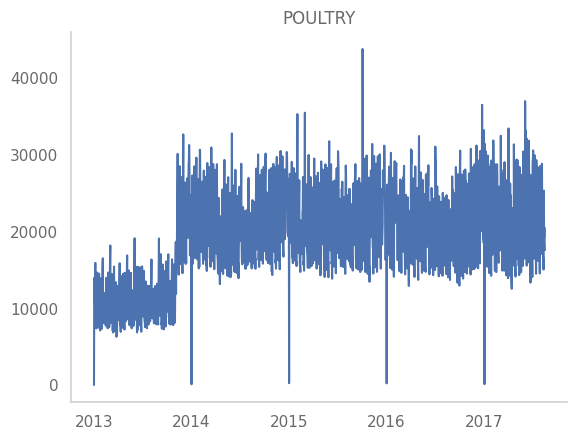

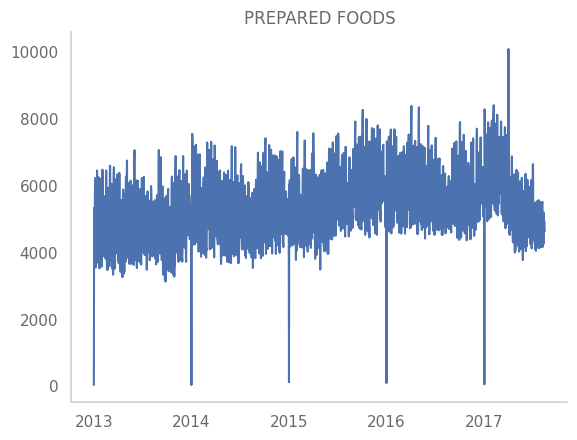

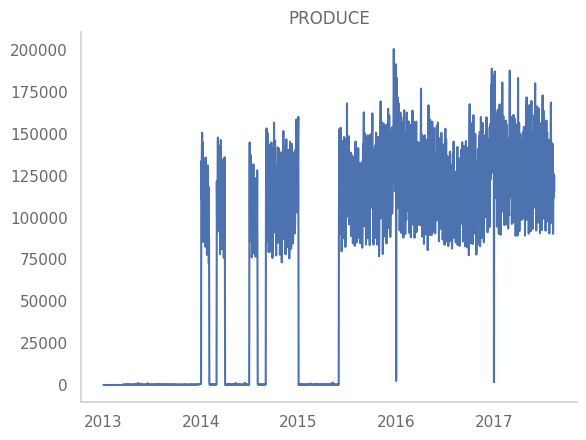

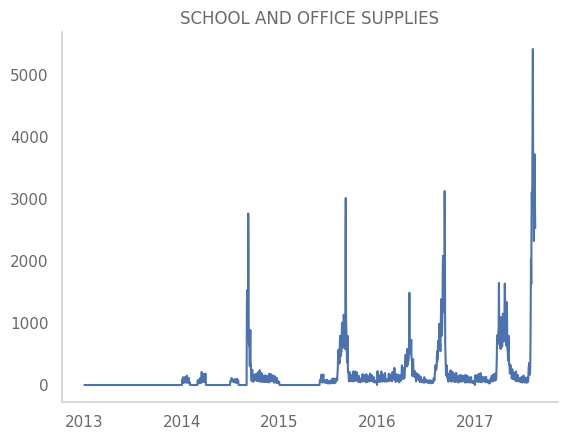

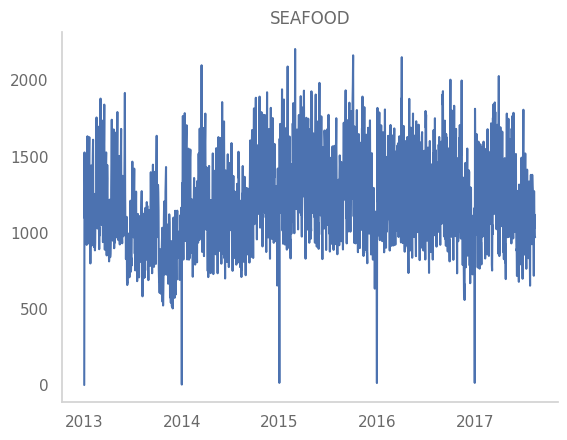

In [21]:
for columns in total_sales_df.columns:
  plt.plot(total_sales_df[columns])
  plt.title(columns)
  plt.show()